In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [3]:
# Download data
stock_data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")
stock_data['Date'] = stock_data.index
stock_data['Days'] = (stock_data.index - stock_data.index[0]).days

[*********************100%***********************]  1 of 1 completed


In [4]:
# Features and target
X = stock_data['Days'].values.reshape(-1, 1)  # Days since start as feature
y = stock_data['Close'].values               # Closing price as target

In [5]:
print(X.shape)
print(y.shape)

(250, 1)
(250, 1)


In [6]:
# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [7]:
# Decision Tree Regression
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # Adjust max_depth for complexity
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

In [8]:
# Predictions
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)


In [9]:
# Evaluate
print("Training MSE:", mean_squared_error(y_train, y_pred_train))
print("Testing MSE:", mean_squared_error(y_test, y_pred_test))
print("Training R2:", r2_score(y_train, y_pred_train))
print("Testing R2:", r2_score(y_test, y_pred_test))


Training MSE: 3.4451652359885374
Testing MSE: 147.76245644583142
Training R2: 0.9881950389584342
Testing R2: -0.8335609630930925


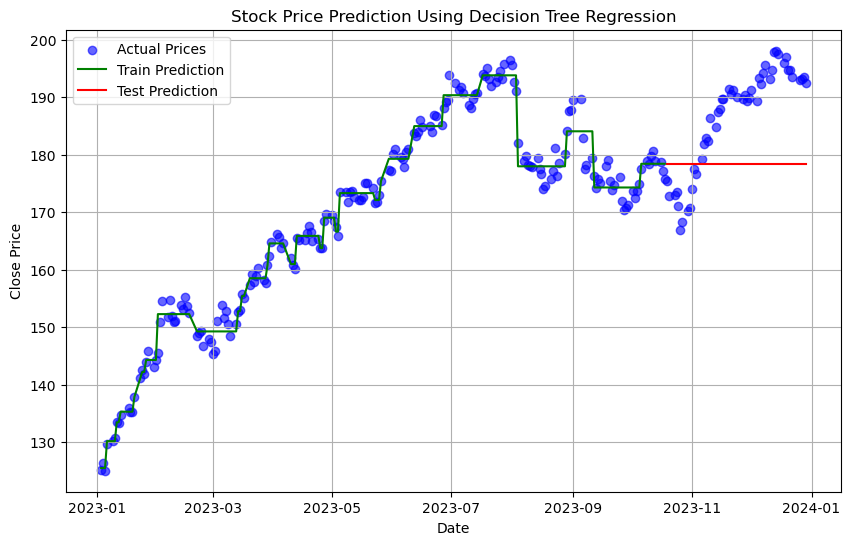

In [10]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(stock_data['Date'], y, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(stock_data['Date'][:split_index], y_pred_train, label='Train Prediction', color='green')
plt.plot(stock_data['Date'][split_index:], y_pred_test, label='Test Prediction', color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Prediction Using Decision Tree Regression")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

Hyperparameter tuning

In [12]:
# Initialize models and hyperparameter ranges for regression
models = {
    'LinearRegression': (LinearRegression(), {}),
    'DecisionTreeRegressor': (DecisionTreeRegressor(random_state=42), {'max_depth': [None, 5, 10, 15]}),
    'RandomForestRegressor': (RandomForestRegressor(random_state=42), {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10, 15]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
}

model_results = {}
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']


# Perform k-fold cross-validation for each model
for name, (model, params) in models.items():
    print(f"\nEvaluating Model: {name}")
    
    best_mean_cv_mse = float('inf')  # Lower is better for MSE
    best_mean_cv_mae = float('inf')
    best_mean_cv_r2 = float('-inf')  # Higher is better for R2
    best_predictions = None
    best_params = None
    
    # Loop over each hyperparameter combination
    for param_combination in ParameterGrid(params):
        # Set parameters for the current model
        model.set_params(**param_combination)
        
        # Create a pipeline with a StandardScaler and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation for each metric
        cv_scores = {}
        for metric in scoring_metrics:
            cv_scores[metric] = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=metric, n_jobs=-1)
            y_pred_train = cross_val_predict(pipeline, X_train, y_train, cv=kf, n_jobs=-1)
            # print(f"Prediction: {y_pred}")
            # print('End predict')
        
        # Print scores for each metric
        # for metric, scores in cv_scores.items():
        #     print(f"Parameters: {param_combination} => {metric}: {scores}")
        
        # Calculate mean scores for each metric
        mean_cv_mse = -np.mean(cv_scores['neg_mean_squared_error'])  # Convert to positive MSE
        mean_cv_mae = -np.mean(cv_scores['neg_mean_absolute_error'])  # Convert to positive MAE
        mean_cv_r2 = np.mean(cv_scores['r2'])
        
        # Update the best parameters based on MSE
        if mean_cv_mse < best_mean_cv_mse:
            best_mean_cv_mse = mean_cv_mse
            best_mean_cv_mae = mean_cv_mae
            best_mean_cv_r2 = mean_cv_r2
            best_predictions = y_pred_train
            best_params = param_combination
    
    # Save results for the model
    model_results[name] = {
        'Best Cross-Validation MSE': best_mean_cv_mse,
        'Best Cross-Validation MAE': best_mean_cv_mae,
        'Best Cross-Validation R2': best_mean_cv_r2,
        'Best Predictions train': best_predictions,
        'Best Parameters': best_params
    }
    
    print(f"Best Cross-Validation Mean MSE: {best_mean_cv_mse:.2f}")
    print(f"Best Cross-Validation Mean MAE: {best_mean_cv_mae:.2f}")
    print(f"Best Cross-Validation Mean R2: {best_mean_cv_r2:.2f}")
    print(f"Best Parameters: {best_params}")

# Determine the best models based on each metric
best_mse_model = min(model_results, key=lambda model: model_results[model]['Best Cross-Validation MSE'])
best_mae_model = min(model_results, key=lambda model: model_results[model]['Best Cross-Validation MAE'])
best_r2_model = max(model_results, key=lambda model: model_results[model]['Best Cross-Validation R2'])

# Print the best models and their metrics
print("\nBest Models for Each Metric:")
print(f"Best Model (MSE): {best_mse_model}")
print(f"Metrics: MSE={model_results[best_mse_model]['Best Cross-Validation MSE']:.4f}, Parameters: {model_results[best_mse_model]['Best Parameters']}")

print(f"\nBest Model (MAE): {best_mae_model}")
print(f"Metrics: MAE={model_results[best_mae_model]['Best Cross-Validation MAE']:.4f}, Parameters: {model_results[best_mae_model]['Best Parameters']}")

print(f"\nBest Model (R²): {best_r2_model}")
print(f"Metrics: R²={model_results[best_r2_model]['Best Cross-Validation R2']:.4f}, Parameters: {model_results[best_r2_model]['Best Parameters']}")




Evaluating Model: LinearRegression
Best Cross-Validation Mean MSE: 100.88
Best Cross-Validation Mean MAE: 8.32
Best Cross-Validation Mean R2: 0.62
Best Parameters: {}

Evaluating Model: DecisionTreeRegressor
Best Cross-Validation Mean MSE: 6.56
Best Cross-Validation Mean MAE: 1.86
Best Cross-Validation Mean R2: 0.98
Best Parameters: {'max_depth': 10}

Evaluating Model: RandomForestRegressor
Best Cross-Validation Mean MSE: 4.88
Best Cross-Validation Mean MAE: 1.62
Best Cross-Validation Mean R2: 0.98
Best Parameters: {'max_depth': None, 'n_estimators': 100}

Evaluating Model: SVR
Best Cross-Validation Mean MSE: 19.66
Best Cross-Validation Mean MAE: 3.53
Best Cross-Validation Mean R2: 0.93
Best Parameters: {'C': 10, 'kernel': 'rbf'}

Best Models for Each Metric:
Best Model (MSE): RandomForestRegressor
Metrics: MSE=4.8798, Parameters: {'max_depth': None, 'n_estimators': 100}

Best Model (MAE): RandomForestRegressor
Metrics: MAE=1.6242, Parameters: {'max_depth': None, 'n_estimators': 100}


Predict the train and test dataset with the best parameters

In [13]:
best_models = model_results.copy()

# Dictionary to store predictions from all models
model_predictions = {}
model_training_predictions = {}

# Generate models with their best hyperparameters
for name, (model_class, _) in models.items():
    best_params = model_results[name]['Best Parameters']
    
    # Instantiate the model with its best parameters
    if name == 'LinearRegression':
        best_models[name] = LinearRegression(**best_params)
    elif name == 'DecisionTreeRegressor':
        best_models[name] = DecisionTreeRegressor(random_state=42, **best_params)
    elif name == 'RandomForestRegressor':
        best_models[name] = RandomForestRegressor(random_state=42, **best_params)
    elif name == 'SVR':
        best_models[name] = SVR(**best_params)

# Fit all models on the training data and make predictions
for name, model in best_models.items():
    model.fit(X_train, y_train)
    
    # Generate predictions for both training and testing sets
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Store predictions
    model_training_predictions[name] = train_predictions
    model_predictions[name] = test_predictions

c:\Users\Norapath Arjanurak\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Norapath Arjanurak\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Plot the result as visualization

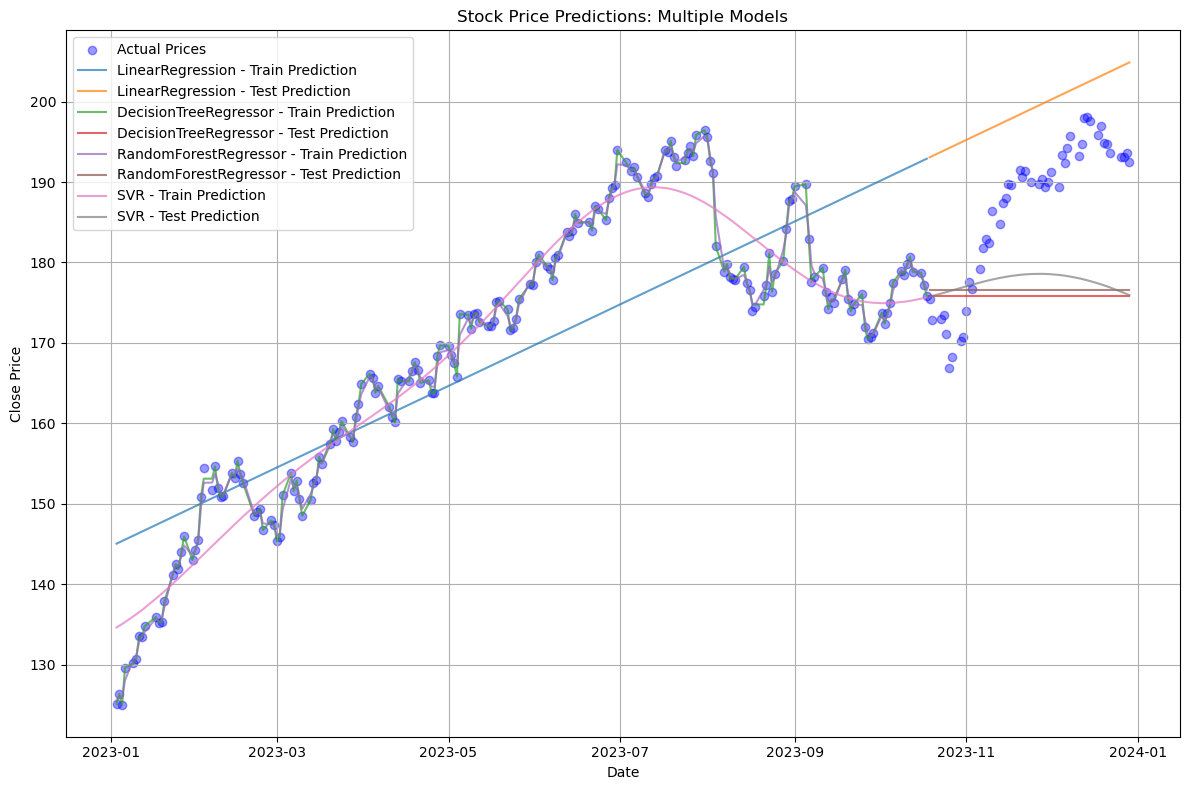

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
# Plot actual prices
plt.scatter(stock_data['Date'], y, label=f'Actual Prices', color='blue', alpha=0.4)
# Iterate over models and their results
for model_name, model_result in model_results.items():
    y_pred_train = model_training_predictions.get(model_name, [0] * split_index)  
    y_pred_test = model_predictions.get(model_name, [0] * (len(stock_data) - split_index))  
    # Plot train predictions
    plt.plot(stock_data['Date'][:split_index], y_pred_train, label=f'{model_name} - Train Prediction', alpha=0.7)
    # Plot test predictions
    plt.plot(stock_data['Date'][split_index:], y_pred_test, label=f'{model_name} - Test Prediction', alpha=0.7)

# Add labels and titles
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions: Multiple Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluate each model with the predict from train and test prediction

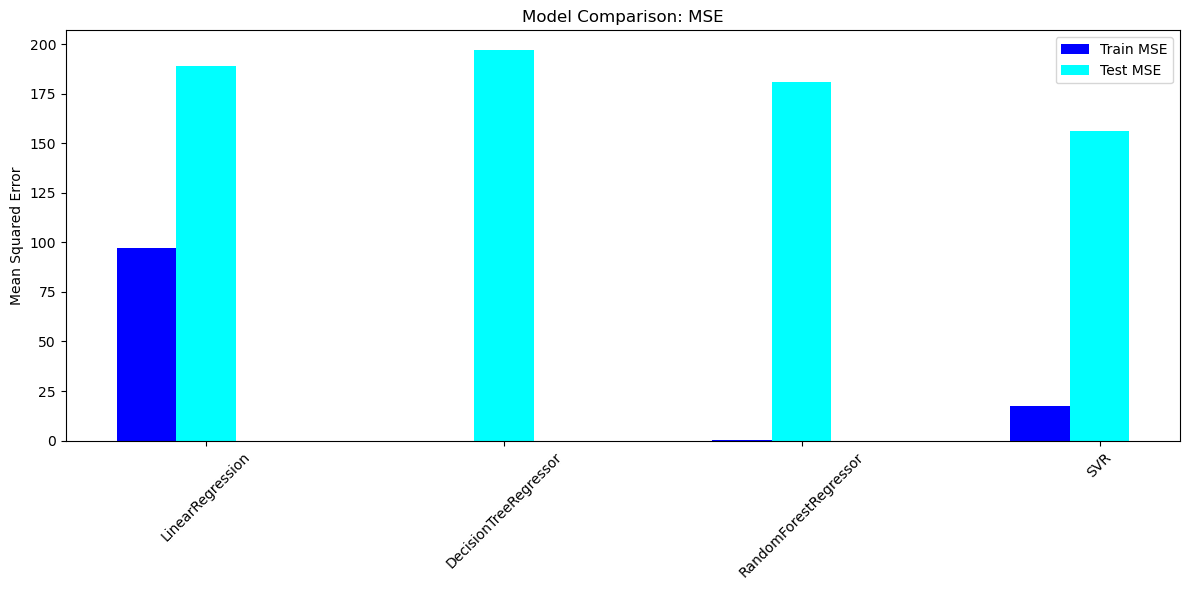

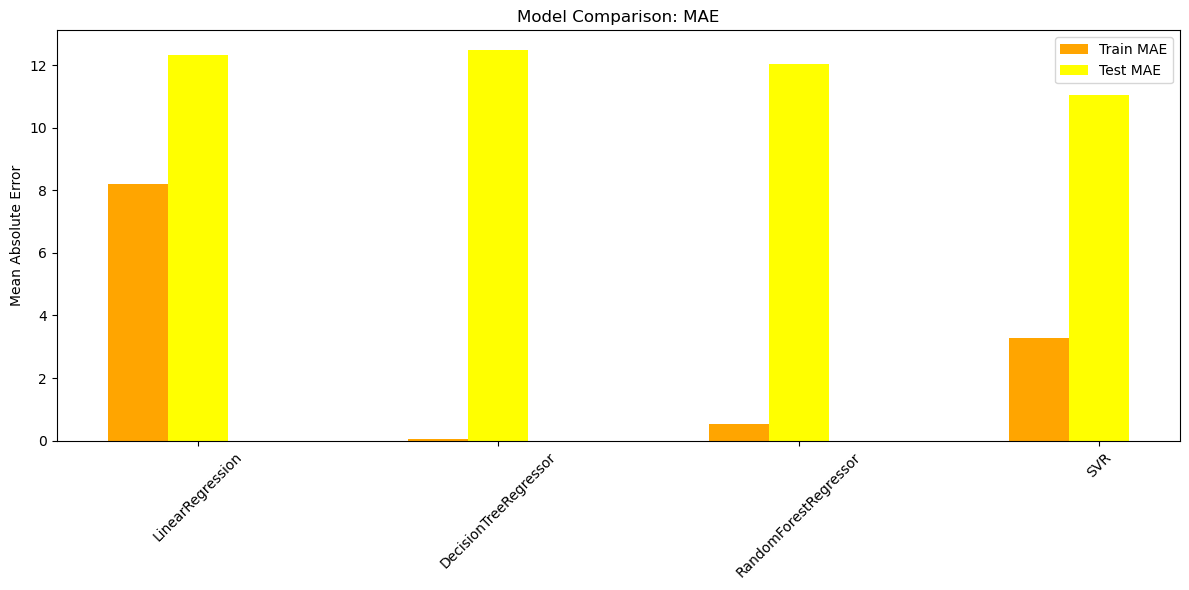

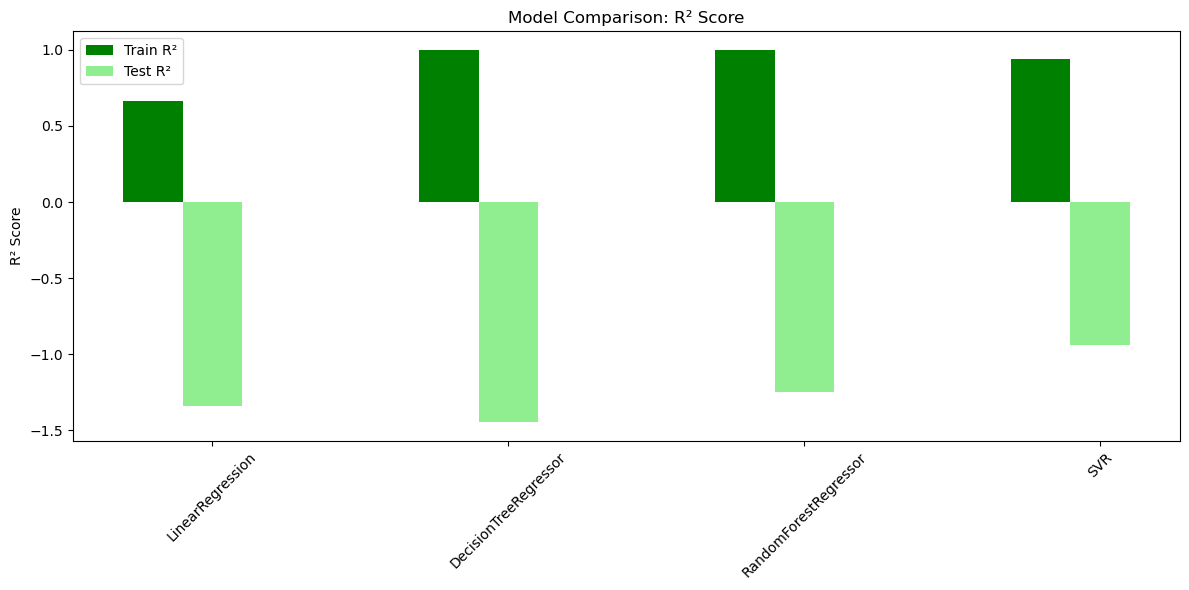


Best Metrics on Training Data:
Best MSE: 0.0343 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 10})
Best MAE: 0.0413 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 10})
Best R²: 0.9999 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 10})

Best Metrics on Test Data:
Best MSE: 156.3807 (Model: SVR, Parameters: {'C': 10, 'kernel': 'rbf'})
Best MAE: 11.0536 (Model: SVR, Parameters: {'C': 10, 'kernel': 'rbf'})
Best R²: -0.9405 (Model: SVR, Parameters: {'C': 10, 'kernel': 'rbf'})


In [15]:
import matplotlib.pyplot as plt

# Dictionary to store comparison results
comparison_results = []
best_mse_train = float('inf')
best_mae_train = float('inf')
best_r2_train = -float('inf')
best_mse_test = float('inf')
best_mae_test = float('inf')
best_r2_test = -float('inf')
best_mse_model_train = None
best_mae_model_train = None
best_r2_model_train = None
best_mse_model_test = None
best_mae_model_test = None
best_r2_model_test = None

# Iterate over all models to calculate metrics for both training and testing
for model_name in model_predictions.keys():
    train_predictions = model_training_predictions[model_name]
    test_predictions = model_predictions[model_name]
    
    # Calculate metrics for training and testing predictions
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Update the best metrics for training and testing
    if train_mse < best_mse_train:
        best_mse_train = train_mse
        best_mse_model_train = model_name
    if train_mae < best_mae_train:
        best_mae_train = train_mae
        best_mae_model_train = model_name
    if train_r2 > best_r2_train:
        best_r2_train = train_r2
        best_r2_model_train = model_name
    if test_mse < best_mse_test:
        best_mse_test = test_mse
        best_mse_model_test = model_name
    if test_mae < best_mae_test:
        best_mae_test = test_mae
        best_mae_model_test = model_name
    if test_r2 > best_r2_test:
        best_r2_test = test_r2
        best_r2_model_test = model_name
    
    # Append results for the table
    comparison_results.append([
        model_name,
        model_results[model_name]['Best Parameters'],
        train_mse, train_mae, train_r2,
        test_mse, test_mae, test_r2
    ])

# Print the comparison results as a table
headers = [
    "Model", "Best Parameters",
    "Train MSE", "Train MAE", "Train R²",
    "Test MSE", "Test MAE", "Test R²"
]
# print(tabulate(comparison_results, headers=headers, tablefmt="grid"))
# Extract metrics for visualization
models = [result[0] for result in comparison_results]
train_mse = [float(result[2]) for result in comparison_results]
train_mae = [float(result[3]) for result in comparison_results]
train_r2 = [float(result[4]) for result in comparison_results]
test_mse = [float(result[5]) for result in comparison_results]
test_mae = [float(result[6]) for result in comparison_results]
test_r2 = [float(result[7]) for result in comparison_results]

# Bar width for grouped bar chart
bar_width = 0.2
indices = np.arange(len(models))

# Plot MSE comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_mse, bar_width, label='Train MSE', color='blue')
plt.bar(indices, test_mse, bar_width, label='Test MSE', color='cyan')
plt.xticks(indices, models, rotation=45)
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison: MSE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_mae, bar_width, label='Train MAE', color='orange')
plt.bar(indices, test_mae, bar_width, label='Test MAE', color='yellow')
plt.xticks(indices, models, rotation=45)
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison: MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_r2, bar_width, label='Train R²', color='green')
plt.bar(indices, test_r2, bar_width, label='Test R²', color='lightgreen')
plt.xticks(indices, models, rotation=45)
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score')
plt.legend()
plt.tight_layout()
plt.show()

# Print the best metrics along with their parameters
print("\nBest Metrics on Training Data:")
print(f"Best MSE: {best_mse_train:.4f} (Model: {best_mse_model_train}, Parameters: {model_results[best_mse_model_train]['Best Parameters']})")
print(f"Best MAE: {best_mae_train:.4f} (Model: {best_mae_model_train}, Parameters: {model_results[best_mae_model_train]['Best Parameters']})")
print(f"Best R²: {best_r2_train:.4f} (Model: {best_r2_model_train}, Parameters: {model_results[best_r2_model_train]['Best Parameters']})")

print("\nBest Metrics on Test Data:")
print(f"Best MSE: {best_mse_test:.4f} (Model: {best_mse_model_test}, Parameters: {model_results[best_mse_model_test]['Best Parameters']})")
print(f"Best MAE: {best_mae_test:.4f} (Model: {best_mae_model_test}, Parameters: {model_results[best_mae_model_test]['Best Parameters']})")
print(f"Best R²: {best_r2_test:.4f} (Model: {best_r2_model_test}, Parameters: {model_results[best_r2_model_test]['Best Parameters']})")


Lstm Time Series

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Epoch 1/50
7/7 [==============================] - 1s 32ms/step - loss: 0.4875 - val_loss: 0.4338
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.4601 - val_loss: 0.4092
Epoch 3/50
7/7 [==============================] - 0s 5ms/step - loss: 0.4343 - val_loss: 0.3857
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.4095 - val_loss: 0.3628
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3853 - val_loss: 0.3403
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3620 - val_loss: 0.3180
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3385 - val_loss: 0.2963
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3155 - val_loss: 0.2751
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.2931 - val_loss: 0.2536
Epoch 10/50
7/7 [==============================] - 0s 5ms/step - loss: 0.2702 - val_loss: 0.2322
Epoch 11/50
7/7 [=====================

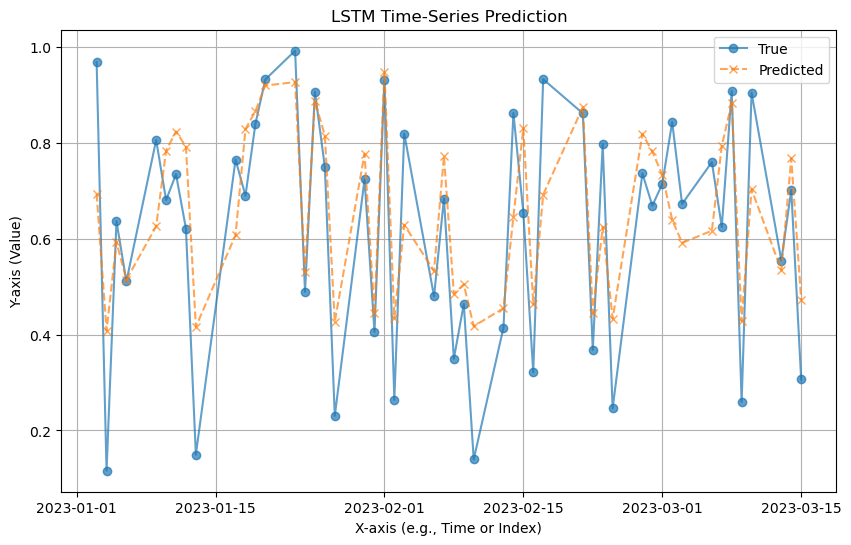

In [22]:
# Generate sample time-series data
# def generate_time_series_data(n_samples, n_steps):
#     X = np.array([np.sin(0.1 * i) + 0.1 * np.random.normal() for i in range(n_samples)])
#     y = np.roll(X, -n_steps)  # Shifted target for prediction
#     return X[:-n_steps], y[:-n_steps]

# Parameters
# n_samples = 1000
# n_steps = 10

# Generate data
# X_raw, y_raw = generate_time_series_data(n_samples, n_steps)

# Reshape data for LSTM ([samples, timesteps, features])
# X = np.array([X_raw[i:i + n_steps] for i in range(len(X_raw) - n_steps)])
# y = y_raw[n_steps:]

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(y_test.shape)
# Predict and plot results
y_pred = model.predict(X_test)
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'][:50], y_test, label='True', marker='o', linestyle='-', alpha=0.7)
plt.plot(stock_data['Date'][:50], y_pred.flatten(), label='Predicted', marker='x', linestyle='--', alpha=0.7)
plt.xlabel("X-axis (e.g., Time or Index)")
plt.ylabel("Y-axis (Value)")
plt.legend()
plt.title("LSTM Time-Series Prediction")
plt.grid()
plt.show()
